In [1]:
import tensorflow_constrained_optimization as tfco
import os
import sys
import tempfile
import urllib3
import time
import pickle

import math
import random
import numpy as np
import pandas as pd
import warnings
from six.moves import xrange
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

tf.disable_eager_execution()

warnings.filterwarnings('ignore')
%matplotlib inline
from tensorflow import keras
from tensorflow.keras import Model

# import tensorflow_datasets as tfds
# tfds.disable_progress_bar()

from matplotlib.ticker import StrMethodFormatter
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn import svm, neighbors, tree
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score

from fairlearn.reductions import ExponentiatedGradient
from fairlearn._input_validation import _validate_and_reformat_input
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

import shap
shap.initjs()

from IPython.display import display, Markdown, Latex, HTML
import statistics

from fairlearn.reductions import GridSearch, DemographicParity, ErrorRate, TruePositiveRateParity, EqualizedOdds
import numpy as np
from datetime import datetime

## Setup data

In [2]:
# Get Data

CATEGORICAL_COLUMNS = [
    'workclass', 'education', 'marital_status', 'occupation', 'relationship',
    'race', 'gender', 'native_country'
]
CONTINUOUS_COLUMNS = [
    'age', 'capital_gain', 'capital_loss', 'hours_per_week', 'education_num'
]
COLUMNS = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'gender',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
    'income_bracket'
]
LABEL_COLUMN = 'label'

PROTECTED_COLUMNS = [
    'gender_Female',
    'gender_Male',
    'race_White',
    'race_Black',
    'race_Other'
]

def get_data():
    train_df_raw = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", names=COLUMNS, skipinitialspace=True)
    test_df_raw = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test", names=COLUMNS, skipinitialspace=True, skiprows=1)

    train_df_raw[LABEL_COLUMN] = (train_df_raw['income_bracket'].apply(lambda x: '>50K' in x)).astype(int)
    test_df_raw[LABEL_COLUMN] = (test_df_raw['income_bracket'].apply(lambda x: '>50K' in x)).astype(int)
    # Preprocessing Features
    pd.options.mode.chained_assignment = None  # default='warn'

    # Functions for preprocessing categorical and continuous columns.
    def binarize_categorical_columns(input_train_df, input_test_df, categorical_columns=[]):

        def fix_columns(input_train_df, input_test_df):
            test_df_missing_cols = set(input_train_df.columns) - set(input_test_df.columns)
            for c in test_df_missing_cols:
                input_test_df[c] = 0
                train_df_missing_cols = set(input_test_df.columns) - set(input_train_df.columns)
            for c in train_df_missing_cols:
                input_train_df[c] = 0
                input_train_df = input_train_df[input_test_df.columns]
            return input_train_df, input_test_df

        # Binarize categorical columns.
        binarized_train_df = pd.get_dummies(input_train_df, columns=categorical_columns)
        binarized_test_df = pd.get_dummies(input_test_df, columns=categorical_columns)
        # Make sure the train and test dataframes have the same binarized columns.
        fixed_train_df, fixed_test_df = fix_columns(binarized_train_df, binarized_test_df)
        return fixed_train_df, fixed_test_df

    def bucketize_continuous_column(input_train_df,
                                  input_test_df,
                                  continuous_column_name,
                                  num_quantiles=None,
                                  bins=None):
        assert (num_quantiles is None or bins is None)
        if num_quantiles is not None:
            train_quantized, bins_quantized = pd.qcut(
              input_train_df[continuous_column_name],
              num_quantiles,
              retbins=True,
              labels=False)
            input_train_df[continuous_column_name] = pd.cut(
              input_train_df[continuous_column_name], bins_quantized, labels=False)
            input_test_df[continuous_column_name] = pd.cut(
              input_test_df[continuous_column_name], bins_quantized, labels=False)
        elif bins is not None:
            input_train_df[continuous_column_name] = pd.cut(
              input_train_df[continuous_column_name], bins, labels=False)
            input_test_df[continuous_column_name] = pd.cut(
              input_test_df[continuous_column_name], bins, labels=False)

    # Filter out all columns except the ones specified.
    train_df = train_df_raw[CATEGORICAL_COLUMNS + CONTINUOUS_COLUMNS + [LABEL_COLUMN]]
    test_df = test_df_raw[CATEGORICAL_COLUMNS + CONTINUOUS_COLUMNS + [LABEL_COLUMN]]
    
    # Bucketize continuous columns.
    bucketize_continuous_column(train_df, test_df, 'age', num_quantiles=4)
    bucketize_continuous_column(train_df, test_df, 'capital_gain', bins=[-1, 1, 4000, 10000, 100000])
    bucketize_continuous_column(train_df, test_df, 'capital_loss', bins=[-1, 1, 1800, 1950, 4500])
    bucketize_continuous_column(train_df, test_df, 'hours_per_week', bins=[0, 39, 41, 50, 100])
    bucketize_continuous_column(train_df, test_df, 'education_num', bins=[0, 8, 9, 11, 16])
    train_df, test_df = binarize_categorical_columns(train_df, test_df, categorical_columns=CATEGORICAL_COLUMNS + CONTINUOUS_COLUMNS)
    feature_names = list(train_df.keys())
    feature_names.remove(LABEL_COLUMN)
    num_features = len(feature_names)
    
    return train_df, test_df, feature_names
train_df, test_df, FEATURE_NAMES = get_data()


class BuildFunction:
    def __init__(self, D):
        self.D = D
        
    def __call__(self):
        model = Sequential()
        model.add(Dense(100, input_dim=D, activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        # Compile model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[
                                                                        tf.keras.metrics.Accuracy(), 
                                                                        tf.keras.metrics.Recall(),
                                                                        tf.keras.metrics.TruePositives(),
                                                                        tf.keras.metrics.Precision()
                                                                        ])
        return model
        
def create_model_creator(D):
    def create_keras_model():
        model = Sequential()
        model.add(Dense(100, input_dim=D, activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        # Compile model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[
                                                                        tf.keras.metrics.Accuracy(), 
                                                                        tf.keras.metrics.Recall(),
                                                                        tf.keras.metrics.TruePositives(),
                                                                        tf.keras.metrics.Precision()
                                                                        ])
        return model
    return create_keras_model

class LogRegTF(Model):
    def __init__(self, D):
        super(LogRegTF, self).__init__()
        self.W = tf.Variable(tf.random.normal(shape=[D, 1]))
        self.b = tf.Variable(tf.random.normal(shape=[1, 1]))

    def call(self, x):
        print((tf.matmul(x, self.W) + self.b).shape)
        return tf.matmul(x, self.W) + self.b

class BuildFunctionLogReg:
    def __init__(self, D, opt='adam'):
        self.D = D
        self.opt = opt
        
    def __call__(self):
        model = Sequential()
        model.add(Dense(1, input_dim=D, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', 
                      optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), metrics=[
                                                                        tf.keras.metrics.Accuracy(), 
                                                                        tf.keras.metrics.Recall(),
                                                                        tf.keras.metrics.TruePositives(),
                                                                        tf.keras.metrics.Precision()
                                                                        ])
        return model

class BuildFunctionLogRegCat:
    def __init__(self, D, opt='adam'):
        self.D = D
        self.opt = opt
        
    def __call__(self):
        model = Sequential()
        model.add(Dense(2, input_dim=D, activation='sigmoid'))
        model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), metrics=[
                                                                        tf.keras.metrics.Accuracy(), 
                                                                        tf.keras.metrics.Recall(),
                                                                        tf.keras.metrics.TruePositives(),
                                                                        tf.keras.metrics.Precision()
                                                                        ])
        return model

def fetch_sk_model(name, input_dim, optimizer='adam'):
    if name=='mlp':
        return MLPClassifier(hidden_layer_sizes=(100, 20), verbose=True, max_iter=10000, solver=optimizer, learning_rate_init=3e-3)
    elif name=='nn-keras':
        return tf.keras.wrappers.scikit_learn.KerasClassifier(
            build_fn=BuildFunction(input_dim), verbose=False)
    elif name=='logistic':
        return LogisticRegression(solver='liblinear', fit_intercept=True)
    elif name=='logistic-keras':
        return tf.keras.wrappers.scikit_learn.KerasClassifier(
            build_fn=BuildFunctionLogRegCat(input_dim, opt=optimizer), verbose=False)
    elif name=='logistic-sgd':
        return SGDClassifier(loss='log', learning_rate='constant', alpha=0, eta0=0.1, max_iter=1)
    elif name=='linear_svc':
        return LinearSVC(penalty='l1')
    elif name=='gbm':
        return GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                                          max_depth=1)



D = len(FEATURE_NAMES)

X_train_all, y_train_all, A_train_all = train_df[FEATURE_NAMES], train_df[LABEL_COLUMN], train_df[PROTECTED_COLUMNS]
X_test_all, y_test_all, A_test_all = test_df[FEATURE_NAMES], test_df[LABEL_COLUMN], test_df[PROTECTED_COLUMNS]

In [3]:
A_train_all.shape

(32561, 4)

# Unmitigated model
We run this on a simple unmitigated model and check the results

In [4]:
unmit_sklearn = fetch_sk_model('logistic', D)

## Evaluate an unmitigated model

In [5]:
def run_unmitigated(model, X_tr, A_tr, y_tr, constraint=TruePositiveRateParity, name='None', epochs=1, fit=True,
                   X_te=None, A_te=None, y_te=None):
    result = {}
    result['model'] = model
    a = time.time()
    if fit:
        try: 
            model.fit(X_tr, y_tr, batch_size=X_tr.shape[0], epochs=epochs)
        except:
            model.fit(X_tr, y_tr)
    result['fit_time'] = time.time() - a
    def Qexp_all(X): return model.predict_proba(X)[:, 1]
    
    # violation of log res
    _, y_tr, A_tr = _validate_and_reformat_input(
            X_tr, y_tr, enforce_binary_labels=True, sensitive_features=A_tr)
    disparity_moment = constraint()
    disparity_moment.load_data(X_tr, y_tr,
                               sensitive_features=A_tr)
    violation_expgrad_all = disparity_moment.gamma(Qexp_all).max()
    result['violation'] = violation_expgrad_all
    # error of log res
    error = ErrorRate()
    error.load_data(X_tr, y_tr,
                    sensitive_features=A_tr)
    error_expgrad_all = error.gamma(Qexp_all)[0]
    result['error'] = error_expgrad_all
    print('[{}] Exponentiated gradient : Violation: {}; Error: {}'.format(
        name, violation_expgrad_all, error_expgrad_all))
    if X_te is not None and y_te is not None and A_te is not None:
        # violation of log res
        _, y_te, A_te = _validate_and_reformat_input(
            X_te, y_te, enforce_binary_labels=True, sensitive_features=A_te)
        disparity_moment = constraint()
        disparity_moment.load_data(X_te, y_te,
                                   sensitive_features=A_te)
        te_violation_expgrad_all = disparity_moment.gamma(Qexp_all).max()

        # error of log res
        error = ErrorRate()
        error.load_data(X_te, y_te,
                        sensitive_features=A_te)
        te_error_expgrad_all = error.gamma(Qexp_all)[0]

        print('[TEST][{}] Exponentiated gradient : Violation: {}; Error: {}'.format(name, te_violation_expgrad_all, 
                                                                           te_error_expgrad_all))
        result['test_error'] = te_error_expgrad_all
        result['test_violation'] = te_violation_expgrad_all
    return result

In [6]:
res = run_unmitigated(unmit_sklearn, X_train_all, A_train_all,y_train_all,name='Unmitigated Logreg')

[Unmitigated Logreg] Exponentiated gradient : Violation: 0.13832407278932007; Error: 0.19428385728760628


# Function that calculates metrics on an estimator

In [7]:
def run_metrics(model, X_tr, y_tr, name='None', epochs=1, fit=True, verbose=True,
               X_te=None, y_te=None):
    result = {}
    result['model'] = model
    a = time.time()
    if fit:
        try: 
            model.fit(X_tr, y_tr, batch_size=X_tr.shape[0], epochs=epochs)
        except:
            model.fit(X_tr, y_tr)
    result['fit_time'] = time.time() - a
    result['accuracy'] = accuracy_score(y_tr, model.predict(X_tr))
    if X_te is not None:
        result['test_accuracy'] = accuracy_score(y_te, model.predict(X_te))
    if verbose:
        print(f"[{name}] Accuracy: {result['accuracy']}")
    return result

# Model setup
First, we setup the base models: 
- Scikit-learn's `LogisticRegressionClassifier` 
- Tensorfow Keras' implementation of a `LogisticRegression` - one `Dense` layer followed by a sigmoid. 
- TFCO's model setup.

In [8]:
class BuildFunctionLogRegV3:
    def __init__(self, D, opt='sgd', lr=0.1):
        self.D = D
        self.opt = opt
        self.lr = lr
        
    def __call__(self):
        model = Sequential()
        model.add(Dense(1, input_dim=self.D, activation='sigmoid'))
        if self.opt == 'sgd':
            optimizer = tf.keras.optimizers.SGD(learning_rate=self.lr)
        else:
            optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        model.compile(loss='binary_crossentropy', 
                      optimizer=optimizer, metrics=[
                                                                        tf.keras.metrics.Accuracy(), 
                                                                        tf.keras.metrics.Recall(),
                                                                        tf.keras.metrics.TruePositives(),
                                                                        tf.keras.metrics.Precision()
                                                                        ])
        return model

def get_sklearn(config):
    params = {
        'loss': 'log',
        'alpha': 0,
        'learning_rate':'constant'
    }
    params.update(config)
#     model = SGDClassifier(loss='log', learning_rate='constant', alpha=0, eta0=0.1, max_iter=1)
    model = SGDClassifier(**params)
    return model



def get_keras(config, opt='sgd'):
    model = tf.keras.wrappers.scikit_learn.KerasClassifier(
            build_fn=BuildFunctionLogRegV3(D, lr=config['lr'], opt=opt), verbose=False)
    return model

# TFCO model setup

In [9]:
class Model(object):
    def __init__(self,
                 tpr_max_diff=0):
        tf.random.set_random_seed(123)
        self.tpr_max_diff = tpr_max_diff
        num_features = len(FEATURE_NAMES)
        self.features_placeholder = tf.placeholder(
            tf.float32, shape=(None, num_features), name='features_placeholder')
        self.labels_placeholder = tf.placeholder(
            tf.float32, shape=(None, 1), name='labels_placeholder')
        self.protected_placeholders = [tf.placeholder(tf.float32, shape=(None, 1), name=attribute+"_placeholder") for attribute in PROTECTED_COLUMNS]
        # We use a linear model.
        self.predictions_tensor = tf.layers.dense(inputs=self.features_placeholder, units=1, activation=None)


    def build_train_op(self,
                       learning_rate,
                       unconstrained=False,
                      constraint='tp'):
        ctx = tfco.rate_context(self.predictions_tensor, self.labels_placeholder)
        positive_slice = ctx.subset(self.labels_placeholder > 0) 
        overall_tpr = tfco.positive_prediction_rate(positive_slice)
        constraints = []
        if not unconstrained:
            if constraint=='tp':
                for placeholder in self.protected_placeholders:
                    slice_tpr = tfco.positive_prediction_rate(ctx.subset((placeholder > 0) & (self.labels_placeholder > 0)))
                    constraints.append(slice_tpr >= overall_tpr - self.tpr_max_diff)
                    constraints.append(slice_tpr <= overall_tpr + self.tpr_max_diff)
            else:
                overall_acc = tfco.accuracy_rate(ctx)
                # TODO: add just for EqualizedOdss
                for placeholder in self.protected_placeholders:
                    slice_tpr_1 = tfco.accuracy_rate(ctx.subset(placeholder > 0))
                    slice_tpr_0 = tfco.accuracy_rate(ctx.subset(placeholder <= 0))
                    constraints.append(slice_tpr_0 >= overall_acc - self.tpr_max_diff)
                    constraints.append(slice_tpr_0 <= overall_acc + self.tpr_max_diff)
                    constraints.append(slice_tpr_1 >= overall_acc - self.tpr_max_diff)
                    constraints.append(slice_tpr_1 <= overall_acc + self.tpr_max_diff)
        
        mp = tfco.RateMinimizationProblem(tfco.error_rate(ctx), constraints)
        opt = tfco.ProxyLagrangianOptimizerV1(tf.train.AdamOptimizer(learning_rate))
        self.train_op = opt.minimize(mp)
        return self.train_op
  
    def feed_dict_helper(self, dataframe):
        feed_dict = {self.features_placeholder:
                  dataframe[FEATURE_NAMES],
              self.labels_placeholder:
                  dataframe[[LABEL_COLUMN]],}
        for i, protected_attribute in enumerate(PROTECTED_COLUMNS):
            feed_dict[self.protected_placeholders[i]] = dataframe[[protected_attribute]]
        return feed_dict

def training_generator(model,
                       train_df,
                       test_df,
                       minibatch_size,
                       num_iterations_per_loop=1,
                       num_loops=1):
    random.seed(31337)
    num_rows = train_df.shape[0]
    minibatch_size = min(minibatch_size, num_rows)
    permutation = list(range(train_df.shape[0]))
    random.shuffle(permutation)

    session = tf.Session()
    session.run((tf.global_variables_initializer(),
               tf.local_variables_initializer()))

    minibatch_start_index = 0
    for n in xrange(num_loops):
        for _ in xrange(num_iterations_per_loop):
            minibatch_indices = []
            while len(minibatch_indices) < minibatch_size:
                minibatch_end_index = (
                minibatch_start_index + minibatch_size - len(minibatch_indices))
                if minibatch_end_index >= num_rows:
                    minibatch_indices += range(minibatch_start_index, num_rows)
                    minibatch_start_index = 0
                else:
                    minibatch_indices += range(minibatch_start_index, minibatch_end_index)
                    minibatch_start_index = minibatch_end_index
                    
            session.run(
                  model.train_op,
                  feed_dict=model.feed_dict_helper(
                      train_df.iloc[[permutation[ii] for ii in minibatch_indices]]))

        train_predictions = session.run(
            model.predictions_tensor,
            feed_dict=model.feed_dict_helper(train_df))
        test_predictions = session.run(
            model.predictions_tensor,
            feed_dict=model.feed_dict_helper(test_df))

        yield (train_predictions, test_predictions)

def error_rate(predictions, labels):
    signed_labels = (
      (labels > 0).astype(np.float32) - (labels <= 0).astype(np.float32))
    numerator = (np.multiply(signed_labels, predictions) <= 0).sum()
    denominator = predictions.shape[0]
    return float(numerator) / float(denominator)


def positive_prediction_rate(predictions, subset):
    numerator = np.multiply((predictions > 0).astype(np.float32),
                          (subset > 0).astype(np.float32)).sum()
    denominator = (subset > 0).sum()
    return float(numerator) / float(denominator)

def tpr(df):
    """Measure the true positive rate."""
    fp = sum((df['predictions'] >= 0.0) & (df[LABEL_COLUMN] > 0.5))
    ln = sum(df[LABEL_COLUMN] > 0.5)
    return float(fp) / float(ln)

def _get_error_rate_and_constraints(df, tpr_max_diff):
    """Computes the error and fairness violations."""
    error_rate_local = error_rate(df[['predictions']], df[[LABEL_COLUMN]])
    overall_tpr = tpr(df)
    return error_rate_local, [(overall_tpr - tpr_max_diff) - tpr(df[df[protected_attribute] > 0.5]) for protected_attribute in PROTECTED_COLUMNS]

def _get_exp_error_rate_constraints(cand_dist, error_rates_vector, constraints_matrix):
    """Computes the expected error and fairness violations on a randomized solution."""
    expected_error_rate = np.dot(cand_dist, error_rates_vector)
    expected_constraints = np.matmul(cand_dist, constraints_matrix)
    return expected_error_rate, expected_constraints

def training_helper(model,
                    train_df,
                    test_df,
                    minibatch_size,
                    num_iterations_per_loop=1,
                    num_loops=1):
    train_error_rate_vector = []
    train_constraints_matrix = []
    test_error_rate_vector = []
    test_constraints_matrix = []
    for train, test in training_generator(
      model, train_df, test_df, minibatch_size, num_iterations_per_loop,
      num_loops):
        train_df['predictions'] = train
        test_df['predictions'] = test

        train_error_rate, train_constraints = _get_error_rate_and_constraints(
          train_df, model.tpr_max_diff)
        train_error_rate_vector.append(train_error_rate)
        train_constraints_matrix.append(train_constraints)

        test_error_rate, test_constraints = _get_error_rate_and_constraints(
            test_df, model.tpr_max_diff)
        test_error_rate_vector.append(test_error_rate)
        test_constraints_matrix.append(test_constraints)

    return (train_error_rate_vector, train_constraints_matrix, test_error_rate_vector, test_constraints_matrix)

## Let's see this in a sample run with the untunes hyperparameters parameters

In [10]:
lr = 0.046415888336127774
epoch = 120
sklearn_params = {
            'eta0':lr,
            'max_iter': epoch,
            'learning_rate': 'adaptive'
        }

keras_res = run_metrics(get_keras({'lr':lr}), X_train_all, y_train_all, name='keras', epochs=epoch)

sklearn_res = run_metrics(get_sklearn(sklearn_params), X_train_all, y_train_all, name='sklearn', epochs=epoch)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[keras] Accuracy: 0.8008046435920273
[sklearn] Accuracy: 0.8598016031448665


In [11]:
class ModelWrapper:
    def __init__(self, epsilon=0.05, unconstrained=False, constraint='tp'):
        print(f"eppsilon: {epsilon}")
        self.model = Model(tpr_max_diff=epsilon)
        self.constraint = constraint
        self.model.build_train_op(0.01,unconstrained=unconstrained, constraint=self.constraint)
    
    def fit(self,train_df, test_df):
        return training_helper(
          self.model,
          train_df,
          test_df,
          100,
          num_iterations_per_loop=326,
          num_loops=40)
    def predict(self, X):
        session = tf.Session()
        session.run((tf.global_variables_initializer(),
                   tf.local_variables_initializer()))
        preds = session.run(
            self.model.predictions_tensor,
            feed_dict={self.model.features_placeholder:X})
        preds = session.run(
            tf.keras.backend.flatten(preds)
        )
        return (preds > 0).astype(int)
    
    def predict_t(self, X):
        session = tf.Session()
        session.run((tf.global_variables_initializer(),
                   tf.local_variables_initializer()))
        preds = session.run(
            self.model.predictions_tensor,
            feed_dict={self.model.features_placeholder:X})
        preds = session.run(
            tf.keras.backend.flatten(preds)
        )
        return preds
    
    def predict_proba(self, X):
        session = tf.Session()
        session.run((tf.global_variables_initializer(),
                   tf.local_variables_initializer()))
        preds = session.run(
            self.model.predictions_tensor,
            feed_dict={self.model.features_placeholder:X})
        return 1/(1 + np.exp(preds.flatten()))

## Results of Hyperparam search
After doing hyperparameter search, these are the best paramters for the model are:

In [12]:
min_keras_lr = 0.6161550277583344
min_sklearn_lr = 0.10536102768906645
min_sklearn_epoch = 30
min_keras_epoch = 110

In [13]:
def get_best_model(name, D):
    if name=='keras':
        return get_keras({'lr': min_keras_lr}, opt='adam')
    elif name=='sklearn':
        return get_sklearn({
            'eta0':min_sklearn_lr,
            'max_iter': min_sklearn_epoch,
            'learning_rate': 'adaptive'
        })
keras_res = run_metrics(get_best_model('keras', D), X_train_all, y_train_all, name='keras', epochs=epoch)

sklearn_res = run_metrics(get_best_model('sklearn', D), X_train_all, y_train_all, name='sklearn', epochs=epoch)

[keras] Accuracy: 0.8603544117195417
[sklearn] Accuracy: 0.8602929885445779


# Experiment functions
First is the method that runs `ExponentiatedGradient`. 

In [14]:
def run_expgrad(model, X_tr, A_tr, y_tr, constraint=TruePositiveRateParity, 
                X_te=None, A_te=None, y_te=None, eps=0.01, nu=1e-6,
                max_iter=50,
                eta0=2.0,
                name='None'
               ):
    expgrad = ExponentiatedGradient(
        model,
        constraints=constraint(difference_bound=eps), nu=nu,
        eta0=eta0,
        max_iter=max_iter
    )
    res = {}
    res['model'] = model
    res['expgrad'] = expgrad
    
    a=time.time()
    _, y_tr, A_tr = _validate_and_reformat_input(
            X_tr, y_tr, enforce_binary_labels=True, sensitive_features=A_tr)
    expgrad.fit(X_tr, y_tr,
                           sensitive_features=A_tr)
    b=time.time()
    time_expgrad_all = b-a
    res['fit_time'] = time_expgrad_all
    def Qexp_all(X): return expgrad._pmf_predict(X)[:, 1]
    
    # violation of log res
    try:
        disparity_moment = constraint(difference_bound=eps)
    except:
        disparity_moment = constraint()
    disparity_moment.load_data(X_tr, y_tr,
                               sensitive_features=A_tr)
    violation_expgrad_all = disparity_moment.gamma(Qexp_all).max()
    res['violation'] = violation_expgrad_all
    # error of log res
    error_expgrad_all = 1-accuracy_score(y_tr, expgrad.predict(X_tr))
    res['error'] = error_expgrad_all
    print('[{}] Exponentiated gradient : Time: {} seconds; Violation: {}; Error: {}'.format(
        name, time_expgrad_all, violation_expgrad_all, error_expgrad_all))
    
    if X_te is not None and y_te is not None and A_te is not None:
        # violation of log res
        _, y_te, A_te = _validate_and_reformat_input(
            X_te, y_te, enforce_binary_labels=True, sensitive_features=A_te)
        disparity_moment = constraint(difference_bound=eps)
        disparity_moment.load_data(X_te, y_te,
                                   sensitive_features=A_te)
        te_violation_expgrad_all = disparity_moment.gamma(Qexp_all).max()

        # error of model
        te_error_expgrad_all = 1-accuracy_score(y_te, expgrad.predict(X_te))

        print('[TEST][{}] Exponentiated gradient : Violation: {}; Error: {}'.format(name, te_violation_expgrad_all, 
                                                                           te_error_expgrad_all))
        res['test_error'] = te_error_expgrad_all
        res['test_violation'] = te_violation_expgrad_all
    return res

## Next, we define the method that runs the unmitigated model

In [15]:
def run_unmitigated(model, X_tr, A_tr, y_tr, constraint=TruePositiveRateParity, name='None',
                   X_te=None, A_te=None, y_te=None,):
    result = {}
    result['model'] = model
    a = time.time()
    model.fit(X_tr, y_tr)
    result['fit_time'] = time.time() - a
    def Qexp_all(X): return model.predict_proba(X)[:, 1]
    
    # violation of log res
    disparity_moment = constraint()
    _, y_tr, A_tr = _validate_and_reformat_input(
            X_tr, y_tr, enforce_binary_labels=True, sensitive_features=A_tr)
    disparity_moment.load_data(X_tr, y_tr,
                               sensitive_features=A_tr)
    violation_expgrad_all = disparity_moment.gamma(Qexp_all).max()
    result['violation'] = violation_expgrad_all
    
    # error of model
    error_expgrad_all = 1-accuracy_score(y_tr, model.predict(X_tr))
    result['error'] = error_expgrad_all
    print('[{}]: Violation: {}; Error: {}'.format(
        name, violation_expgrad_all, error_expgrad_all))
    
    if X_te is not None and y_te is not None and A_te is not None:
        # violation of log res
        _, y_te, A_te = _validate_and_reformat_input(
            X_te, y_te, enforce_binary_labels=True, sensitive_features=A_te)
        disparity_moment = constraint()
        disparity_moment.load_data(X_te, y_te,
                                   sensitive_features=A_te)
        te_violation_expgrad_all = disparity_moment.gamma(Qexp_all).max()

        # error of log res
        error = ErrorRate()
        error.load_data(X_te, y_te,
                        sensitive_features=A_te)
        te_error_expgrad_all = 1-accuracy_score(y_te, model.predict(X_te))

        print('[TEST][{}]: Violation: {}; Error: {}'.format(name, te_violation_expgrad_all, 
                                                                           te_error_expgrad_all))
        result['test_error'] = te_error_expgrad_all
        result['test_violation'] = te_violation_expgrad_all
    return result

## Lastly, we have the results for TFCO

In [16]:
def run_tfco(model, train_df, test_df, X_tr, y_tr, A_tr, constraint=TruePositiveRateParity, name='None',
                   X_te=None, A_te=None, y_te=None,eps=0.01):
    result = {}
    result['model'] = model
    a = time.time()
    train_errors, train_violations, test_errors, test_violations = model.fit(train_df, test_df)
    result['fit_time'] = time.time() - a
    def Qexp_all(X): return model.predict_proba(X)
    
    # violation of log res
#     if isinstance(constraint, Moment):
#         _, y_tr, A_tr = _validate_and_reformat_input(
#             X_tr, y_tr, enforce_binary_labels=True, sensitive_features=A_tr)
#         disparity_moment = constraint(difference_bound=eps)
#         disparity_moment.load_data(X_tr, y_tr,
#                                    sensitive_features=A_tr)
#         violation_expgrad_all = disparity_moment.gamma(Qexp_all).max()
    result['violation'] = max(train_violations[-1])
    # error of log res
#     error = ErrorRate()
#     error.load_data(X_tr, y_tr,
#                     sensitive_features=A_tr)
    error_expgrad_all = train_errors[-1]
    result['error'] = error_expgrad_all
    print('[{}]: Violation: {}; Error: {}'.format(
        name, result['violation'], error_expgrad_all))
    
    if X_te is not None and y_te is not None and A_te is not None:
        # violation of log res
#         disparity_moment = constraint(difference_bound=eps)
#         disparity_moment.load_data(X_te, y_te,
#                                    sensitive_features=A_te)
        te_violation_expgrad_all = max(test_violations[-1])

        # error of log res
        te_error_expgrad_all = test_errors[-1]

        print('[TEST][{}]: Violation: {}; Error: {}'.format(name, te_violation_expgrad_all, 
                                                                           te_error_expgrad_all))
        result['test_error'] = te_error_expgrad_all
        result['test_violation'] = te_violation_expgrad_all
    return result

## Experiment setup
Here, we setup the configurations that has to be run.  
We run experiemnts for various values of $\epsilon$ and for different models with `TruePositiveParity` as the constraint

In [17]:
exps = [
    {
    'model': 'sklearn',
    'name': 'LogReg sklearn sgd adaptive lr'
},
#     {
#     'model': 'keras',
#     'name': 'LogReg tensorflow adam'
# },
    {
    'model': 'tfco',
    'name': 'TFCO run'
},
# #     {
# #     'model': 'logistic-keras',
# #     'name': 'LogReg tensorflow adam',
# #     'optimizer': 'adam'
# # },
#     {
#     'model': 'nn-keras',
#     'name': 'Neural Network tensorflow sgd',
#     'optimizer': 'sgd'
# },
# {
#     'model': 'gbm',
#     'name': 'Gradient Boosting Classifier sgd',
#     'optimizer': 'sgd'
# }
]
epss = [0.001, 0.01, 0.05, 0.1]
# epss = [0.001,0.005, 0.01]

## Generic experiment method that calls each of these

In [18]:
def run_experiment(exp, X_train_all, A_train_all, y_train_all, constraint=TruePositiveRateParity):
    print(f"Running experiment for model {exp['name']} with eps {exp['eps']} ")
    if exp['model'] != 'tfco':
        return run_expgrad(get_best_model(exp['model'], D), X_train_all, A_train_all, y_train_all, 
                           eps=exp['eps'],name=f"Constrained {exp['name']}",
                           X_te=X_test_all, A_te=A_test_all, y_te=y_test_all
                          )
    else:
        if isinstance(constraint, TruePositiveRateParity):
            constraint = 'tp'
        elif isinstance(constraint, EqualizedOdds):
            constraint='eq_odds'
        return run_tfco(ModelWrapper(epsilon=exp['eps'], constraint=constraint), train_df, test_df, X_train_all, y_train_all, A_train_all,
                           eps=exp['eps'],name=f"Constrained {exp['name']}",
                           X_te=X_test_all, A_te=A_test_all, y_te=y_test_all
                          )

So now, we have the expreiment run configuration setup, the different methods that runs the various algorithms also setup, now lets, run the experiment!

In [19]:
def save_file(name, obj):
    pickle.dump(obj, open(name+'.p', 'wb'))

In [20]:
results = []
filename = datetime.today()
for exp in exps:
    results.append([])
    for eps in epss:
        r = {}
        exp_t = dict(exp)
        exp_t['eps'] = eps
        r['config'] = exp_t
        r['result'] = run_experiment(exp_t, X_train_all, A_train_all, y_train_all)
        results[-1].append(r)
#         save_file(filename, results)
    if exp['model']!='tfco':
        r = {}
        r['config'] = exp
        r['result'] = run_unmitigated(get_best_model(exp['model'], D), X_train_all, A_train_all, y_train_all, name=f"Unmitigated {exp['name']}",
                                     X_te=X_test_all, A_te=A_test_all, y_te=y_test_all)
        results[-1].append(r)
    else:
        r = {}
        r['config'] = exp
        r['result'] = run_tfco(ModelWrapper(epsilon=0.001, unconstrained=True), train_df, test_df, X_train_all, y_train_all, A_train_all,
                           eps=0.001,name=f"Constrained {exp['name']}",
                           X_te=X_test_all, A_te=A_test_all, y_te=y_test_all
                          )
        results[-1].append(r)

Running experiment for model LogReg sklearn sgd adaptive lr with eps 0.001 
[Constrained LogReg sklearn sgd adaptive lr] Exponentiated gradient : Time: 83.7958550453186 seconds; Violation: 0.0010000000000014442; Error: 0.14296243972850953
[TEST][Constrained LogReg sklearn sgd adaptive lr] Exponentiated gradient : Violation: 0.03695955107806581; Error: 0.14636693077820773
Running experiment for model LogReg sklearn sgd adaptive lr with eps 0.01 
[Constrained LogReg sklearn sgd adaptive lr] Exponentiated gradient : Time: 46.926645040512085 seconds; Violation: 0.010000000000001785; Error: 0.14495869291483676
[TEST][Constrained LogReg sklearn sgd adaptive lr] Exponentiated gradient : Violation: 0.05952563548463563; Error: 0.14550703273754684
Running experiment for model LogReg sklearn sgd adaptive lr with eps 0.05 
[Constrained LogReg sklearn sgd adaptive lr] Exponentiated gradient : Time: 40.205172061920166 seconds; Violation: 0.05000000000000171; Error: 0.1414882835293756
[TEST][Constrai

# Plot results
### Training data

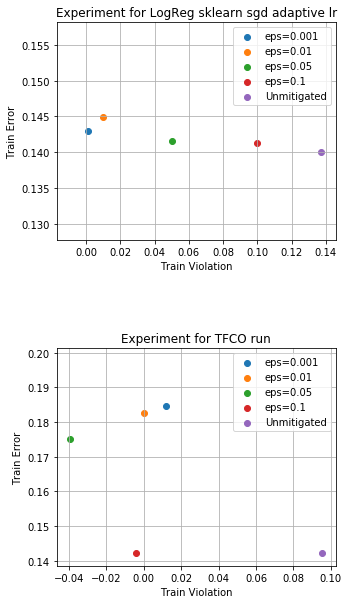

In [21]:
# Train plots
fig, axs = plt.subplots(len(results), 1, gridspec_kw = {'hspace':0.5}, figsize=(5,5*len(results)))

for i in range(len(results)):
    axs[i].set_title(f"Experiment for {results[i][0]['config']['name']}")
    axs[i].grid(True)
    axs[i].set_xlabel('Train Violation')
    axs[i].set_ylabel('Train Error')
    for exp in results[i]:
        if 'eps' in exp['config']:
            axs[i].scatter(exp['result']['violation'], exp['result']['error'], label=f"eps={exp['config']['eps']}")
        else:
            axs[i].scatter(exp['result']['violation'], exp['result']['error'], label=f"Unmitigated")
    axs[i].legend()

## Test data

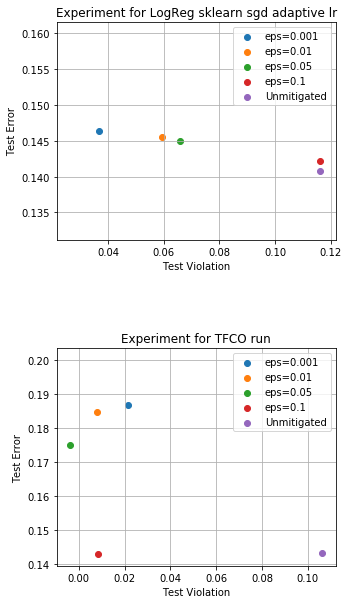

In [22]:
# Test plots
fig, axs = plt.subplots(len(results), 1, gridspec_kw = {'hspace':0.5}, figsize=(5,5*len(results)))

for i in range(len(results)):
    axs[i].set_title(f"Experiment for {results[i][0]['config']['name']}")
    axs[i].grid(True)
    axs[i].set_ylabel('Test Error')
    axs[i].set_xlabel('Test Violation')
    for exp in results[i]:
        if 'eps' in exp['config']:
            try:
                axs[i].scatter(exp['result']['test_violation'], exp['result']['test_error'], label=f"eps={exp['config']['eps']}")
            except:
                pass
        else:
            try:
                axs[i].scatter(exp['result']['test_violation'], exp['result']['test_error'], label=f"Unmitigated")
            except:
                pass
    axs[i].legend()

# Experiment run with `EqualizedOdds`

In [23]:
from fairlearn.reductions import EqualizedOdds
results_eo = []
PROTECTED_COLUMNS = [
    'gender_Female',
    'gender_Male'
]

filename = datetime.today()
for exp in exps:
    results_eo.append([])
    for eps in epss:
        r = {}
        exp_t = dict(exp)
        exp_t['eps'] = eps
        r['config'] = exp_t
        r['result'] = run_experiment(exp_t, X_train_all, A_train_all, y_train_all, constraint=EqualizedOdds)
        results_eo[-1].append(r)
#         save_file(filename, results_eo)
    if exp['model']!='tfco':
        r = {}
        r['config'] = exp
        r['result'] = run_unmitigated(get_best_model(exp['model'], D), X_train_all, A_train_all, y_train_all, name=f"Unmitigated {exp['name']}",
                                     X_te=X_test_all, A_te=A_test_all, y_te=y_test_all)
        results_eo[-1].append(r)
    else:
        r = {}
        r['config'] = exp
        r['result'] = run_tfco(ModelWrapper(epsilon=0.001, unconstrained=True), train_df, test_df, X_train_all, y_train_all, A_train_all,
                           eps=0.001,name=f"Constrained {exp['name']}",
                           X_te=X_test_all, A_te=A_test_all, y_te=y_test_all
                          )
        results_eo[-1].append(r)


Running experiment for model LogReg sklearn sgd adaptive lr with eps 0.001 
[Constrained LogReg sklearn sgd adaptive lr] Exponentiated gradient : Time: 58.63783621788025 seconds; Violation: 0.001000000000001; Error: 0.1446515770400172
[TEST][Constrained LogReg sklearn sgd adaptive lr] Exponentiated gradient : Violation: 0.05225169030127874; Error: 0.14734967139610589
Running experiment for model LogReg sklearn sgd adaptive lr with eps 0.01 
[Constrained LogReg sklearn sgd adaptive lr] Exponentiated gradient : Time: 38.802836894989014 seconds; Violation: 0.01000000000000012; Error: 0.14437517275267964
[TEST][Constrained LogReg sklearn sgd adaptive lr] Exponentiated gradient : Violation: 0.03671891033810648; Error: 0.1470425649530127
Running experiment for model LogReg sklearn sgd adaptive lr with eps 0.05 
[Constrained LogReg sklearn sgd adaptive lr] Exponentiated gradient : Time: 35.532204151153564 seconds; Violation: 0.05000000000000371; Error: 0.14164184146678538
[TEST][Constrained L

# Plot results
### Training data

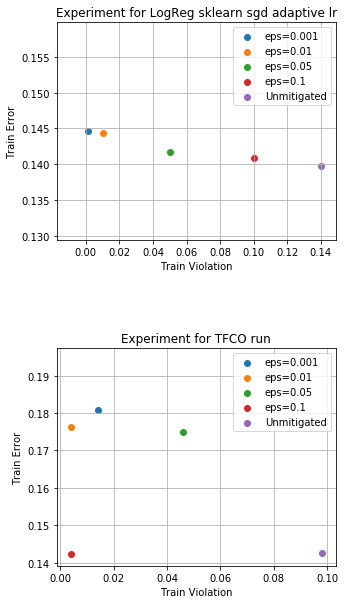

In [24]:
# Train plots
fig, axs = plt.subplots(len(results_eo), 1, gridspec_kw = {'hspace':0.5}, figsize=(5,5*len(results_eo)))

for i in range(len(results_eo)):
    axs[i].set_title(f"Experiment for {results_eo[i][0]['config']['name']}")
    axs[i].grid(True)
    axs[i].set_xlabel('Train Violation')
    axs[i].set_ylabel('Train Error')
    for exp in results_eo[i]:
        if 'eps' in exp['config']:
            axs[i].scatter(np.abs(exp['result']['violation']), exp['result']['error'], label=f"eps={exp['config']['eps']}")
        else:
            axs[i].scatter(np.abs(exp['result']['violation']), exp['result']['error'], label=f"Unmitigated")
    axs[i].legend()

## Test data

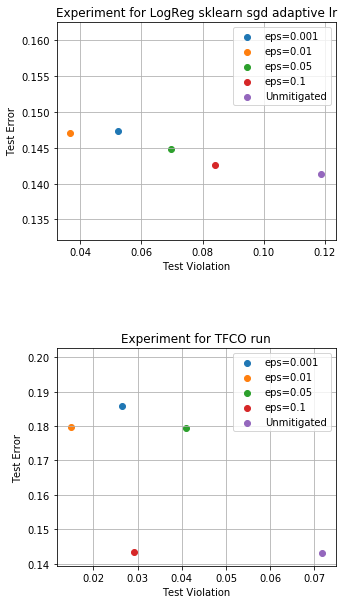

In [25]:
# Test plots
fig, axs = plt.subplots(len(results_eo), 1, gridspec_kw = {'hspace':0.5}, figsize=(5,5*len(results_eo)))

for i in range(len(results_eo)):
    axs[i].set_title(f"Experiment for {results_eo[i][0]['config']['name']}")
    axs[i].grid(True)
    axs[i].set_ylabel('Test Error')
    axs[i].set_xlabel('Test Violation')
    for exp in results_eo[i]:
        if 'eps' in exp['config']:
            try:
                axs[i].scatter(np.abs(exp['result']['test_violation']), exp['result']['test_error'], label=f"eps={exp['config']['eps']}")
            except:
                pass
        else:
            try:
                axs[i].scatter(np.abs(exp['result']['test_violation']), exp['result']['test_error'], label=f"Unmitigated")
            except:
                pass
    axs[i].legend()